# LIBRARIES

In [1]:
from pytrends.request import TrendReq
pytrend = TrendReq()

import matplotlib
import yfinance as yf
import pandas as pd 
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor
from warnings import filterwarnings

filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (30,10)

# DATA PREPERATION

<AxesSubplot:title={'center':'Google Trends Interest Over time in between 2020-05-01 and 2021-01-01'}, xlabel='date'>

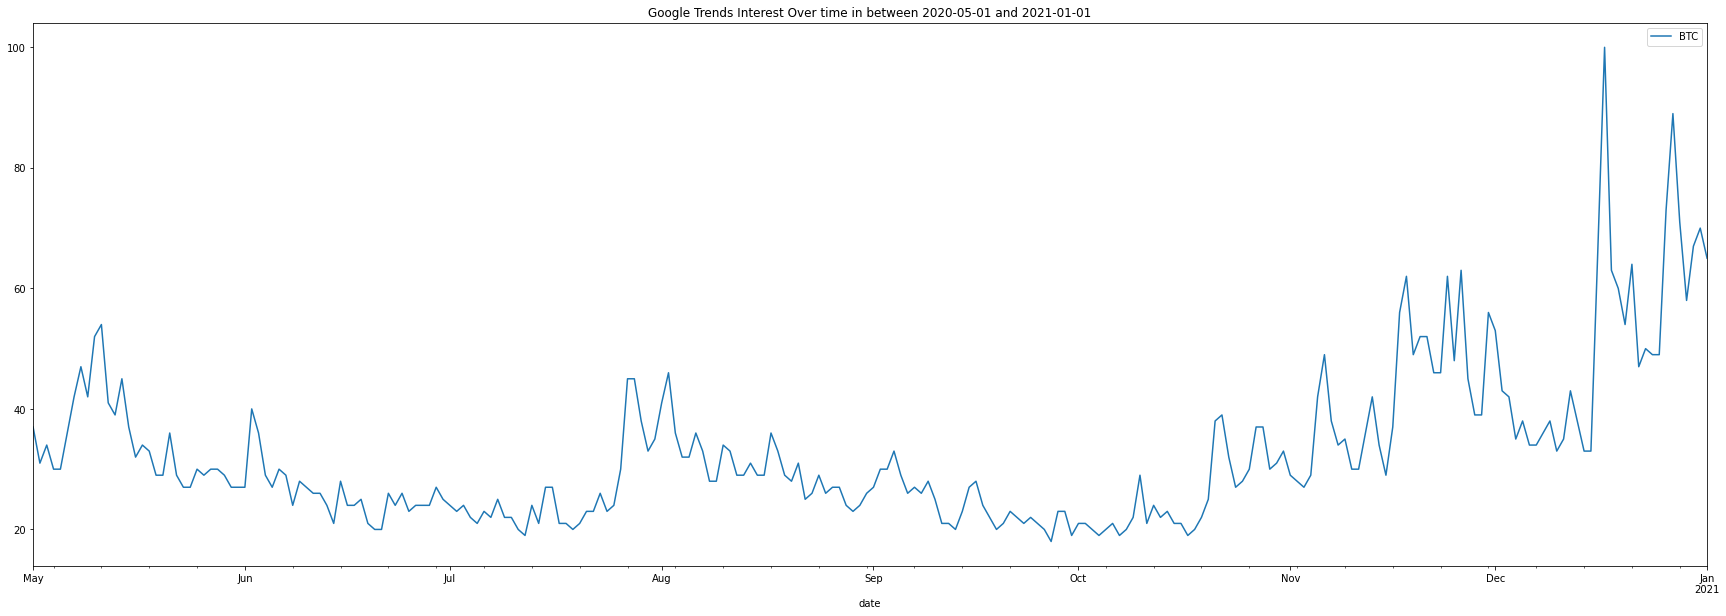

In [2]:
# Pull/Visualize "BTC" keyword searches from the whole World in between 2020-05-01 and 2021-01-01

pytrend.build_payload(kw_list=["BTC"], timeframe = "2020-05-01 2021-01-01")
interest_over_time_df = pytrend.interest_over_time()
interest_over_time_df.plot(title = "Google Trends Interest Over time in between 2020-05-01 and 2021-01-01")

In [3]:
# Pull/Visualize "BTC-USD" real past values in between 2020-05-01 and 2021-01-01

df = yf.download(tickers='BTC-USD', start="2020-05-01", end="2021-01-01")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-30,8797.669922,9440.650391,8533.255859,8658.553711,8658.553711,66964629541
2020-05-01,8672.782227,9048.023438,8667.763672,8864.766602,8864.766602,44068389997
2020-05-02,8869.057617,9007.187500,8811.366211,8988.596680,8988.596680,40134388683
2020-05-03,8983.614258,9167.781250,8830.971680,8897.468750,8897.468750,47101785174
2020-05-04,8895.745117,8956.906250,8645.024414,8912.654297,8912.654297,45718796276


<AxesSubplot:title={'center':'BTC values in between 2020-05-01 and 2021-01-01'}, xlabel='Date'>

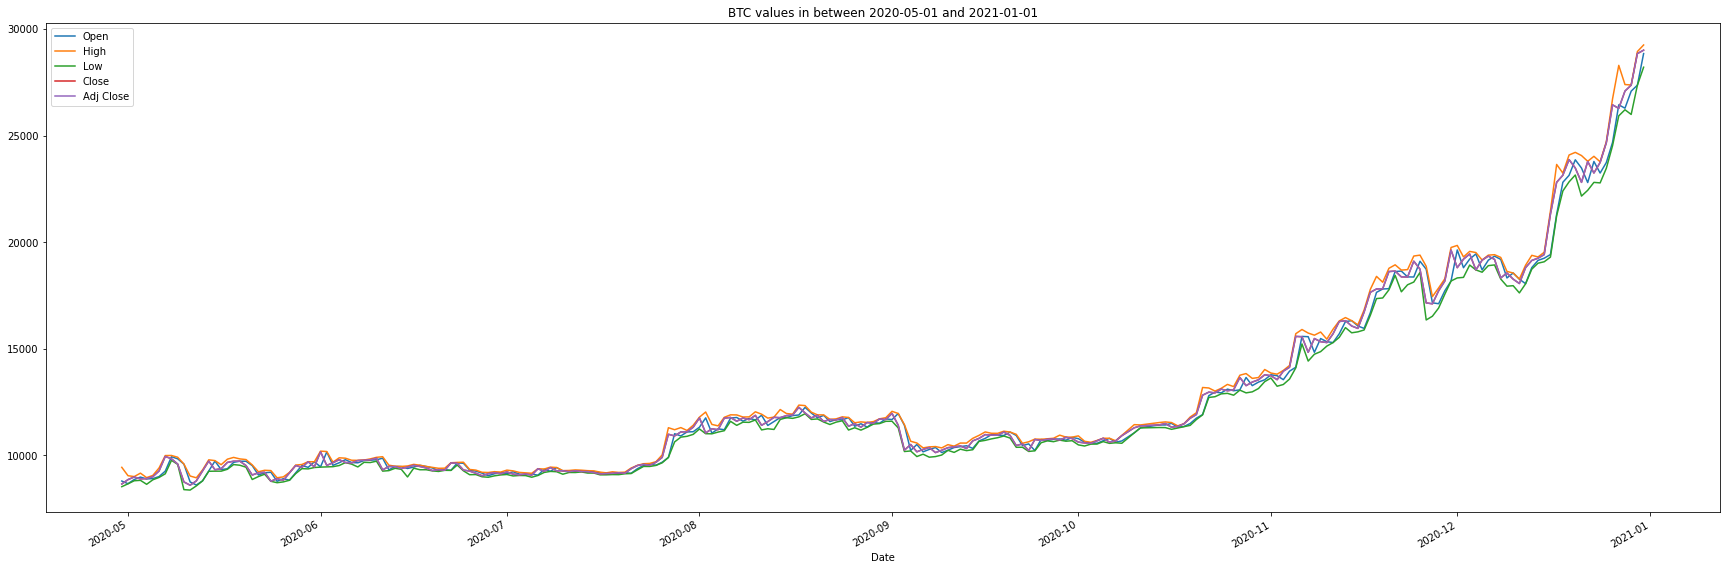

In [4]:
clean_real_past_values_df = df.drop(["Volume"], axis = 1)
clean_real_past_values_df.plot(title = "BTC values in between 2020-05-01 and 2021-01-01")

<AxesSubplot:title={'center':'BTC values and google trends interest over time in between 2020-05-01 and 2021-01-01'}>

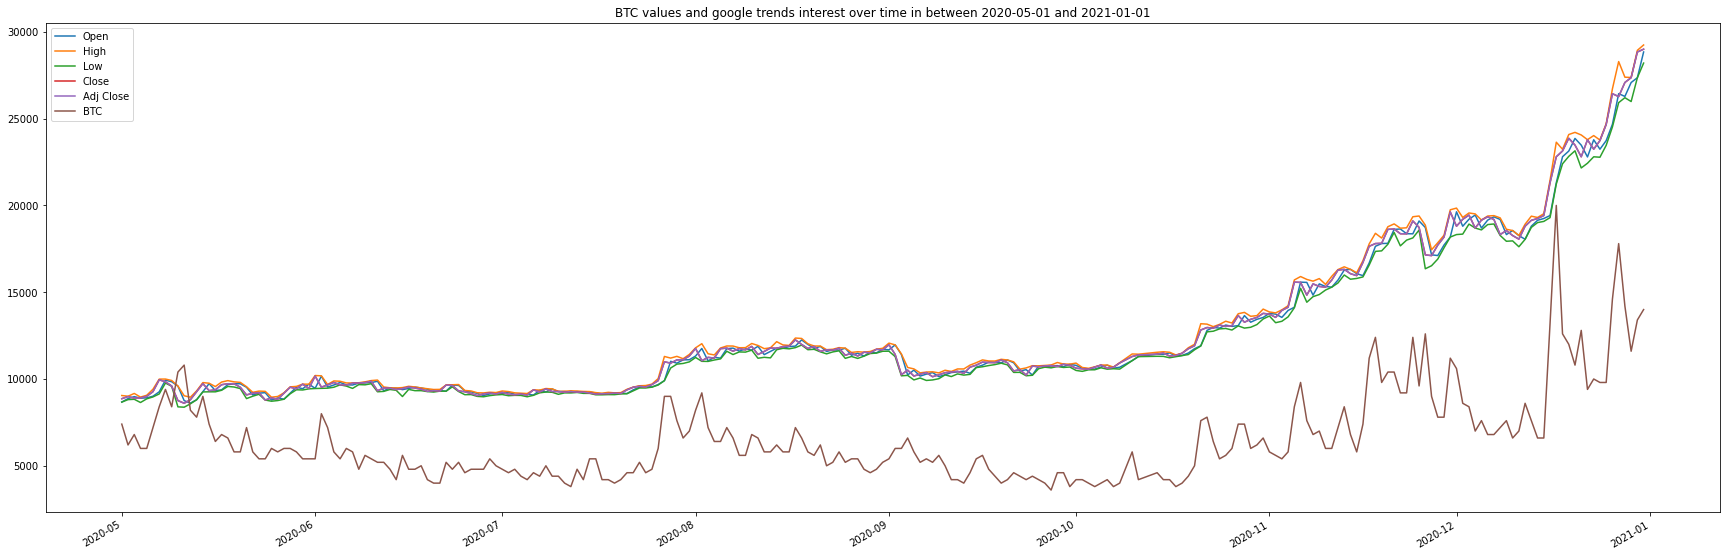

In [5]:
with_trends_df=pd.merge(df, interest_over_time_df*200, how='inner', left_index=True, right_index=True)
with_trends_df.drop(["Volume", "isPartial"], axis = 1, inplace = True)
with_trends_df.plot(title = "BTC values and google trends interest over time in between 2020-05-01 and 2021-01-01")

In [6]:
df = pd.merge(df, interest_over_time_df, how = "inner", left_index = True, right_index = True)

In [7]:
df["Close_change"] = df["Close"].pct_change()
df["Close_change_shifted"] = df["Close_change"].shift(-1)
df.drop(columns = ["Close_change", "isPartial", "Close", "Adj Close"], inplace = True)
df.drop(df.index[-1], inplace=True)

In [8]:
df.head(10)

,Open,High,Low,Volume,BTC,Close_change_shifted
2020-05-01,8672.782227,9048.023438,8667.763672,44068389997,37,0.013969
2020-05-02,8869.057617,9007.187500,8811.366211,40134388683,31,-0.010138
2020-05-03,8983.614258,9167.781250,8830.971680,47101785174,34,0.001707
2020-05-04,8895.745117,8956.906250,8645.024414,45718796276,30,0.010145
2020-05-05,8912.832031,9062.415039,8856.827148,43148462663,30,0.029511
2020-05-06,9007.441406,9411.467773,8966.706055,49371886931,36,0.073662
2020-05-07,9261.895508,9992.664062,9138.322266,61112700562,42,-0.010938
2020-05-08,9936.162109,9996.743164,9767.172852,51780748042,47,-0.025275
2020-05-09,9840.906250,9913.863281,9580.644531,46566121841,42,-0.087292
2020-05-10,9591.168945,9595.581055,8395.107422,63325279337,52,-0.017660


In [9]:
final_df = df.copy()

In [10]:
scaler = MinMaxScaler()
final_df_scaled = scaler.fit_transform(final_df)
final_df_scaled = pd.DataFrame(final_df_scaled, columns = final_df.columns)
final_df_scaled.head()

,Open,High,Low,Volume,BTC,Close_change_shifted
0,0.003328,0.004909,0.015456,0.538101,0.231707,0.548872
1,0.013796,0.002866,0.023020,0.471566,0.158537,0.435163
2,0.019906,0.010901,0.024052,0.589405,0.195122,0.491034
3,0.015219,0.000351,0.014258,0.566015,0.146341,0.530834
4,0.016131,0.005629,0.025414,0.522543,0.146341,0.622184


# MODEL TRAINING

## Arranging X and Y  datasets

In [11]:
y_scaled = final_df_scaled["Close_change_shifted"]
X_scaled = final_df_scaled.drop(["Close_change_shifted", "BTC"], axis = 1)

y_scaled_with_trends = final_df_scaled["Close_change_shifted"]
X_scaled_with_trends = final_df_scaled.drop(["Close_change_shifted"], axis = 1)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size = 0.25, random_state = 123)
X_train_scaled_with_trends, X_test_scaled_with_trends, y_train_scaled_with_trends, y_test_scaled_with_trends = train_test_split(X_scaled_with_trends, y_scaled_with_trends, test_size = 0.25, random_state = 123)

## KNN Model

In [12]:
knn_model_scaled = KNeighborsRegressor()
knn_model_scaled.fit(X_train_scaled, y_train_scaled)

knn_model_scaled_with_trends = KNeighborsRegressor()
knn_model_scaled_with_trends.fit(X_train_scaled_with_trends, y_train_scaled_with_trends)

KNeighborsRegressor()

### Without Trends

In [13]:
y_pred_knn_scaled = knn_model_scaled.predict(X_test_scaled)

In [14]:
scala = final_df_scaled["Close_change_shifted"].max() - final_df_scaled["Close_change_shifted"].min()
print("In the interval", scala, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test_scaled, y_pred_knn_scaled)))
print("MSE: ", mean_squared_error(y_test_scaled, y_pred_knn_scaled))
print("MAE: ", mean_absolute_error(y_test_scaled, y_pred_knn_scaled))

In the interval 1.0 , performance metrics are as follows
RMSE:  0.1327679236949449
MSE:  0.017627321562266707
MAE:  0.09570255916463895


<AxesSubplot:title={'center':'Real Close values as y_test_scaled ; Close predictions with knn as y_pred_knn_scaled'}>

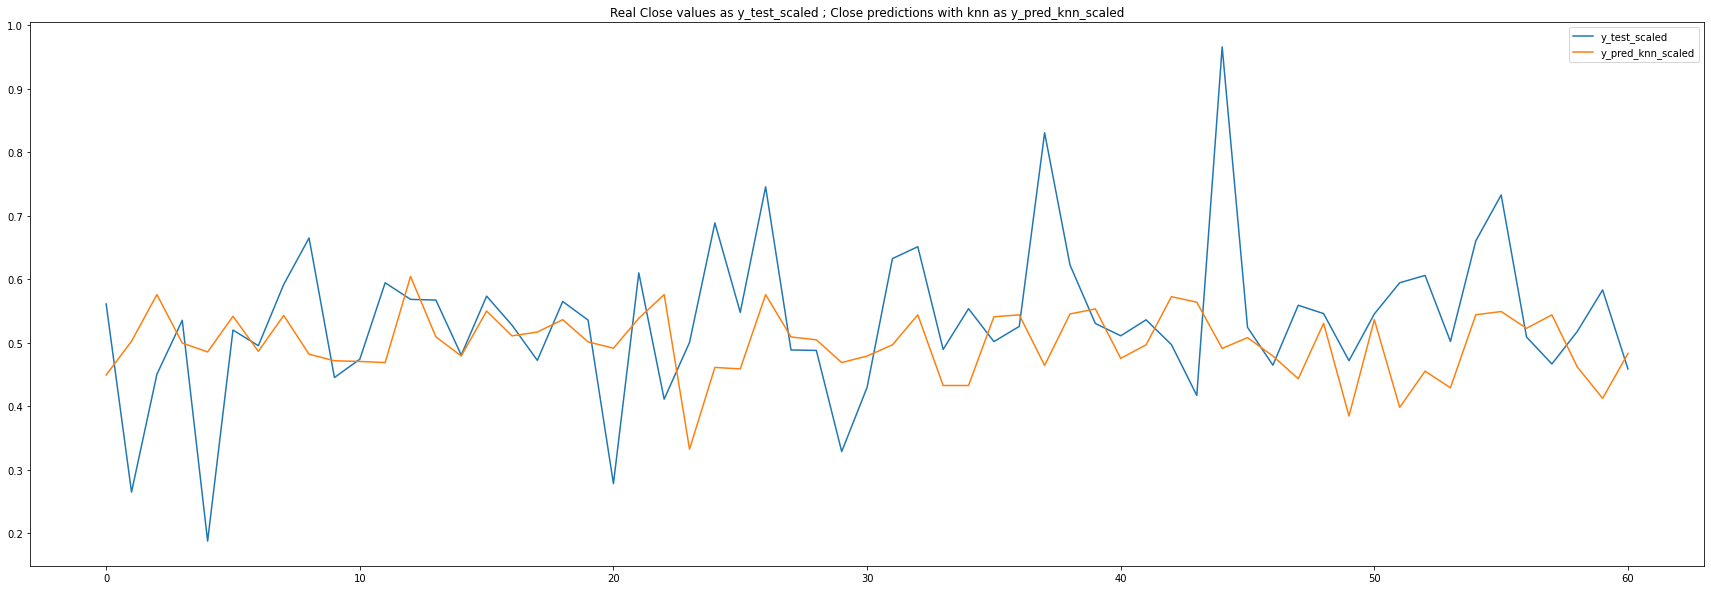

In [15]:
list_of_tuples = list(zip(y_test_scaled, y_pred_knn_scaled))
knn_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test_scaled', 'y_pred_knn_scaled'])
knn_res_df[:100].plot(title ="Real Close values as y_test_scaled ; Close predictions with knn as y_pred_knn_scaled")

### With Trends

In [16]:
y_pred_knn_scaled_with_trends = knn_model_scaled_with_trends.predict(X_test_scaled_with_trends)

In [17]:
scala = final_df_scaled["Close_change_shifted"].max() - final_df_scaled["Close_change_shifted"].min()
print("In the interval", scala, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test_scaled_with_trends, y_pred_knn_scaled_with_trends)))
print("MSE: ", mean_squared_error(y_test_scaled_with_trends, y_pred_knn_scaled_with_trends))
print("MAE: ", mean_absolute_error(y_test_scaled_with_trends, y_pred_knn_scaled_with_trends))

In the interval 1.0 , performance metrics are as follows
RMSE:  0.1280505803526594
MSE:  0.01639695112865288
MAE:  0.09561638393532895


<AxesSubplot:title={'center':'Real Close values as y_test_scaled_with_trends ; Close predictions with knn as y_pred_knn_scaled_with_trends'}>

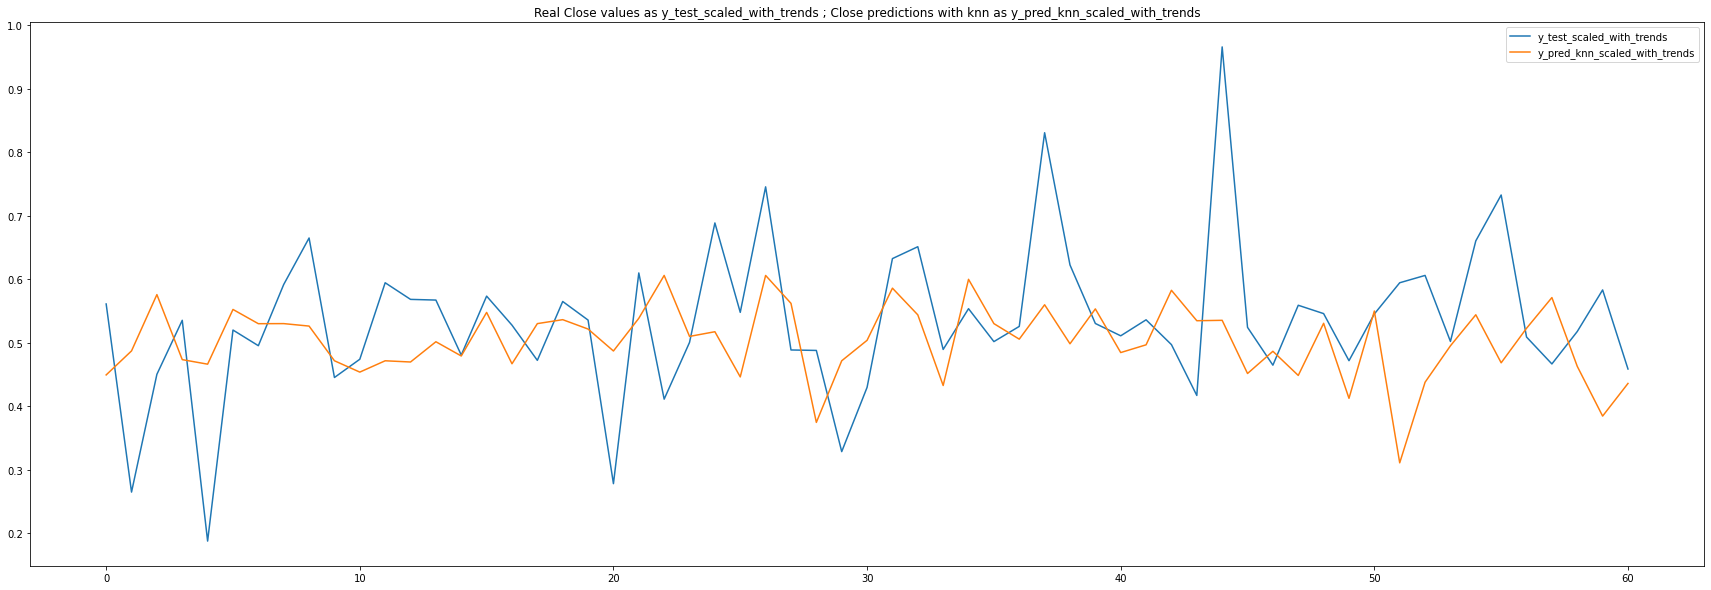

In [18]:
list_of_tuples = list(zip(y_test_scaled_with_trends, y_pred_knn_scaled_with_trends))
knn_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test_scaled_with_trends', 'y_pred_knn_scaled_with_trends'])
knn_res_df[:100].plot(title ="Real Close values as y_test_scaled_with_trends ; Close predictions with knn as y_pred_knn_scaled_with_trends")